In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect
from sqlalchemy import desc

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
#get columns for measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#get columns for station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [74]:
maxdate = session.query(measurement.date).order_by(measurement.date.desc()).first()
maxdate


366

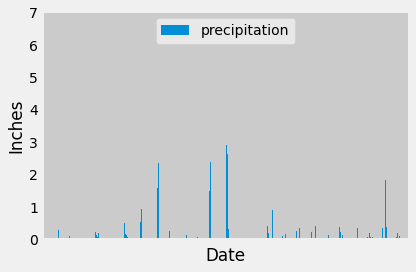

In [131]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
maxdate = session.query(func.max(measurement.date)).all()
# Perform a query to retrieve the data and precipitation scores
prcp_latest= session.query(measurement.prcp, measurement.date).\
                filter(measurement.date >= '2016-08-23').\
                group_by(measurement.date).\
                order_by(desc(measurement.date)).all()

# # Save the query results as a Pandas DataFrame and set the index to the date column
prcp_latest_df = pd.DataFrame(prcp_latest, columns=['precipitation','date'])
prcp_latest_df.set_index('date', inplace= True)
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_latest_df.plot(kind = 'bar')
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)
plt.tight_layout()
plt.show()

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [106]:
# Design a query to show how many stations are available in this dataset?
station_count= session.query(station.station).count()
station_count

9

In [114]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count= session.query(measurement.station, func.count(measurement.station)).\
            group_by(measurement.station).\
            order_by(desc(func.count(measurement.station))).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [115]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temp = session.query(measurement.station, func.min(measurement.tobs), 
                             func.max(measurement.tobs), func.avg(measurement.tobs)).\
                    group_by(measurement.station).all()
station_temp

[('USC00511918', 53.0, 87.0, 71.61596766043456),
 ('USC00513117', 59.0, 85.0, 72.68918420081211),
 ('USC00514830', 58.0, 85.0, 74.8732970027248),
 ('USC00516128', 58.0, 84.0, 70.91500765696784),
 ('USC00517948', 58.0, 87.0, 74.68440233236151),
 ('USC00518838', 58.0, 83.0, 72.72407045009784),
 ('USC00519281', 54.0, 85.0, 71.66378066378067),
 ('USC00519397', 56.0, 87.0, 74.55323054331865),
 ('USC00519523', 56.0, 85.0, 74.5436493068565)]

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


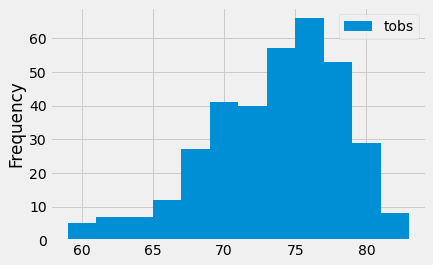

In [130]:
# Choose the station with the highest number of temperature observations.
#station USC00519281 has the highest count
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temps= session.query(measurement.tobs).\
                filter(measurement.station =='USC00519281', measurement.date >= '2016-08-23').all()
temp_df = pd.DataFrame(station_temps, columns= ['tobs'] )
temp_chart = temp_df.plot(kind = 'hist', bins=12)
temp_chart
temp_df

## Bonus Challenge Assignment

In [133]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [150]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Trip_avg_temp= calc_temps('2017-01-01','2018-01-01')

In [167]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(Trip_avg_temp, columns=['TMIN','TAVG','TMAX'])

# trip_chart = plt.bar(10, trip_df['TAVG'])
# trip_chart.yerr = trip_df['TMIN'], trip_df['TMAX']


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
